<p style="text-align: center;"><img alt="school-logo" src="../images/school_logo.png" style="zoom: 50%;" /></p>

<h1 align="center">本科生《深度学习》课程<br>实验报告</h1>
<div style="text-align: center;">
    <div><span style="display: inline-block; width: 65px; text-align: center;">课程名称</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">深度学习</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">实验题目</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">卷积神经网络实验</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">学号</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">21281280</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">姓名</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">柯劲帆</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">班级</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">物联网2101班</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">指导老师</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">张淳杰</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">报告日期</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">2024年1月14日</span></div>
</div>

实验环境：
- OS：Ubuntu 22.04.3 LTS (GNU/Linux 6.5.0-14-generic x86_64)
- CPU：12th Gen Intel(R) Core(TM) i7-12700H
- GPU：NVIDIA GeForce RTX 3070 Ti Laptop
- cuda: 12.3
- conda: miniconda 23.11.0
- python：3.10.13
- torch：2.1.1

In [1]:
import torch
from torch import nn
import numpy as np

from dataset import *
from utils import *

# 2-LSTM

采用手动方式以及调用接口方式实现LSTM，并在至少一种数据集上进行实验。

## 1. 手动实现LSTM

In [2]:
class My_LSTM(nn. Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.gates = nn.Linear(input_size + hidden_size, hidden_size * 4)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn. Tanh()
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        h, c = (torch.zeros(batch_size, self.hidden_size).to(x.device) for _ in range(2))
        y_list = []
        for i in range(seq_len):
            forget_gate, input_gate, output_gate, candidate_cell = \
                self.gates(torch.cat([x[:, i, :], h], dim=-1)).chunk(4, -1)
            forget_gate, input_gate, output_gate = (self.sigmoid(g)
                                                    for g in (forget_gate, input_gate, output_gate))
            c = forget_gate * c + input_gate * self.tanh(candidate_cell)
            h = output_gate * self.tanh(c)
            y_list.append(h)
        return torch.stack(y_list, dim=1), (h, c)

Epoch [10/80], Train Loss: 0.0040, Train RMSE: 18.1494, Val Loss: 0.0003, Val RMSE: 4.780678, Time Use: 0.147s
Epoch [20/80], Train Loss: 0.0025, Train RMSE: 14.3149, Val Loss: 0.0003, Val RMSE: 4.578024, Time Use: 0.178s
Epoch [30/80], Train Loss: 0.0017, Train RMSE: 11.8165, Val Loss: 0.0002, Val RMSE: 3.741790, Time Use: 0.139s
Epoch [40/80], Train Loss: 0.0014, Train RMSE: 10.6514, Val Loss: 0.0002, Val RMSE: 3.637066, Time Use: 0.139s
Epoch [50/80], Train Loss: 0.0012, Train RMSE: 9.8197, Val Loss: 0.0001, Val RMSE: 3.316868, Time Use: 0.177s
Epoch [60/80], Train Loss: 0.0011, Train RMSE: 9.5689, Val Loss: 0.0003, Val RMSE: 4.567028, Time Use: 0.157s
Epoch [70/80], Train Loss: 0.0010, Train RMSE: 8.9631, Val Loss: 0.0001, Val RMSE: 3.467211, Time Use: 0.160s
Epoch [80/80], Train Loss: 0.0009, Train RMSE: 8.4533, Val Loss: 0.0001, Val RMSE: 2.941697, Time Use: 0.176s
Final result: Get best validation rmse 2.9417 at epoch 79, Total time 13.30s
Test result: Test RMSE: 7.6536220947564

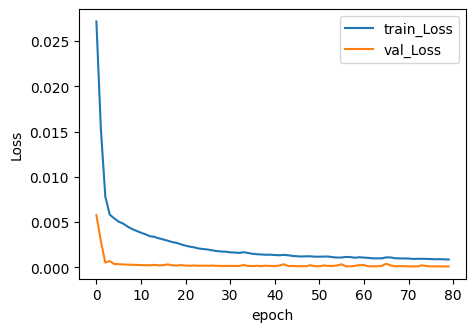

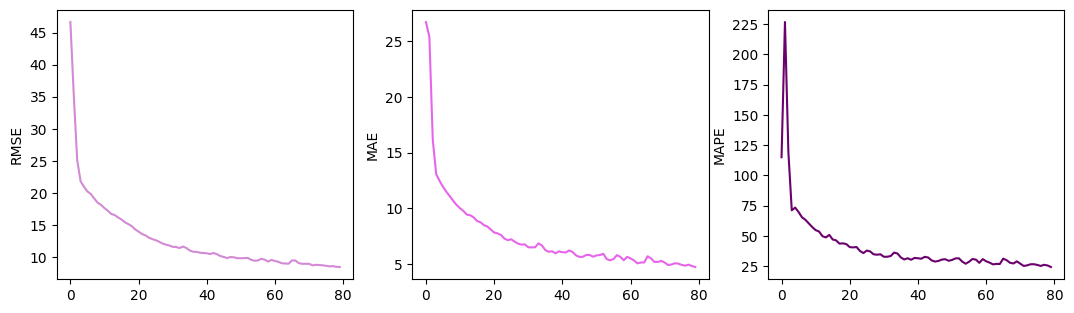

In [3]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.lstm = My_LSTM(input_size=input_size, hidden_size=hidden_size)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, output_size), 
            nn.LeakyReLU()
        )
        
    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :].squeeze(-1)
        x = self.fc(x).squeeze(-1)
        return x


if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size = 256
    learning_rate = 1e-4
    num_epoch = 80
    
    KrakowData = KrakowDataset()
    train_set, val_set, test_set = KrakowData.construct_set(0.6, 0.2)
    train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=14, drop_last=True)
    val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=14, drop_last=True)
    test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=14, drop_last=True)
    input_size = train_set.seqs.shape[-1]
    seq_len = 12
    hidden_size = 512
    output_size = 1

    criterion = nn.MSELoss()
    model = Model(input_size=input_size, hidden_size=hidden_size, output_size=output_size).to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    
    train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, stop_epoch = train(
        net=model, train_iter=train_loader, val_iter=val_loader, test_iter=test_loader, loss_fn=criterion, 
        denormalize_fn=KrakowData.denormalize, optimizer=optimizer, num_epoch=num_epoch, early_stop=20, 
        device=device, num_print_epoch_round=10
    )
    visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
    plot_metric(train_score_lst)

Epoch [10/80], Train Loss: 0.0040, Train RMSE: 72.2414, Val Loss: 0.0040, Val RMSE: 66.408207, Time Use: 0.292s
Epoch [20/80], Train Loss: 0.0033, Train RMSE: 65.1506, Val Loss: 0.0036, Val RMSE: 61.594708, Time Use: 0.350s
Epoch [30/80], Train Loss: 0.0030, Train RMSE: 62.3693, Val Loss: 0.0033, Val RMSE: 57.117139, Time Use: 0.340s
Epoch [40/80], Train Loss: 0.0028, Train RMSE: 59.9032, Val Loss: 0.0031, Val RMSE: 55.539818, Time Use: 0.263s
Epoch [50/80], Train Loss: 0.0026, Train RMSE: 57.6373, Val Loss: 0.0030, Val RMSE: 53.239917, Time Use: 0.331s
Epoch [60/80], Train Loss: 0.0024, Train RMSE: 56.3542, Val Loss: 0.0028, Val RMSE: 51.892160, Time Use: 0.348s
Epoch [70/80], Train Loss: 0.0024, Train RMSE: 55.3275, Val Loss: 0.0027, Val RMSE: 50.398722, Time Use: 0.303s
Epoch [80/80], Train Loss: 0.0023, Train RMSE: 54.7876, Val Loss: 0.0027, Val RMSE: 50.838990, Time Use: 0.289s
Final result: Get best validation rmse 49.9455 at epoch 76, Total time 25.03s
Test result: Test RMSE: 49

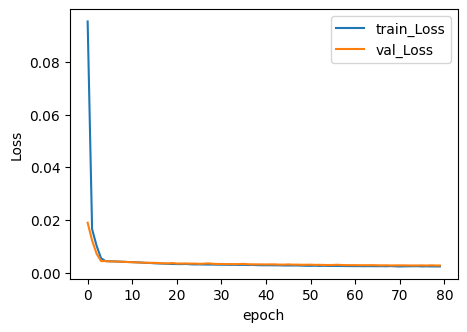

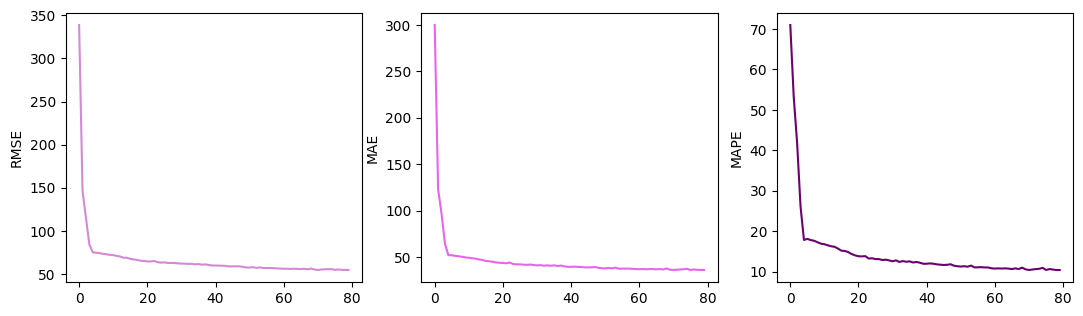

In [4]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size = 256
    learning_rate = 1e-4
    num_epoch = 80
    
    TrafficData = TrafficDataset()
    train_set, val_set, test_set = TrafficData.construct_set(0.6, 0.2)
    train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=14, drop_last=True)
    val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=14, drop_last=True)
    test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=14, drop_last=True)
    input_size = train_set.seqs.shape[-1]
    seq_len = 12
    hidden_size = 512
    output_size = 1

    criterion = nn.MSELoss()
    model = Model(input_size, hidden_size, output_size).to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    
    train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, stop_epoch = train(
        net=model, train_iter=train_loader, val_iter=val_loader, test_iter=test_loader, loss_fn=criterion, 
        denormalize_fn=TrafficData.denormalize, optimizer=optimizer, num_epoch=num_epoch, early_stop=20, 
        device=device, num_print_epoch_round=10
    )
    visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
    plot_metric(train_score_lst)

## 2. 调用`nn.LSTM`接口

Epoch [10/80], Train Loss: 0.0043, Train RMSE: 18.7706, Val Loss: 0.0003, Val RMSE: 5.136751, Time Use: 0.089s
Epoch [20/80], Train Loss: 0.0026, Train RMSE: 14.5427, Val Loss: 0.0003, Val RMSE: 4.726993, Time Use: 0.088s
Epoch [30/80], Train Loss: 0.0018, Train RMSE: 11.9107, Val Loss: 0.0002, Val RMSE: 4.312610, Time Use: 0.090s
Epoch [40/80], Train Loss: 0.0014, Train RMSE: 10.6293, Val Loss: 0.0002, Val RMSE: 3.892872, Time Use: 0.093s
Epoch [50/80], Train Loss: 0.0012, Train RMSE: 9.8172, Val Loss: 0.0001, Val RMSE: 3.341181, Time Use: 0.093s
Epoch [60/80], Train Loss: 0.0010, Train RMSE: 9.1600, Val Loss: 0.0001, Val RMSE: 3.179504, Time Use: 0.089s
Epoch [70/80], Train Loss: 0.0010, Train RMSE: 9.2402, Val Loss: 0.0004, Val RMSE: 5.955032, Time Use: 0.093s
Epoch [80/80], Train Loss: 0.0009, Train RMSE: 8.5972, Val Loss: 0.0001, Val RMSE: 3.067192, Time Use: 0.093s
Final result: Get best validation rmse 3.0273 at epoch 75, Total time 7.25s
Test result: Test RMSE: 7.60089747934863

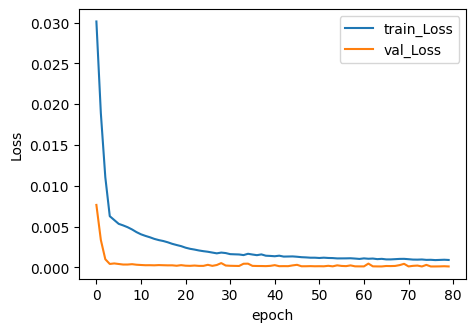

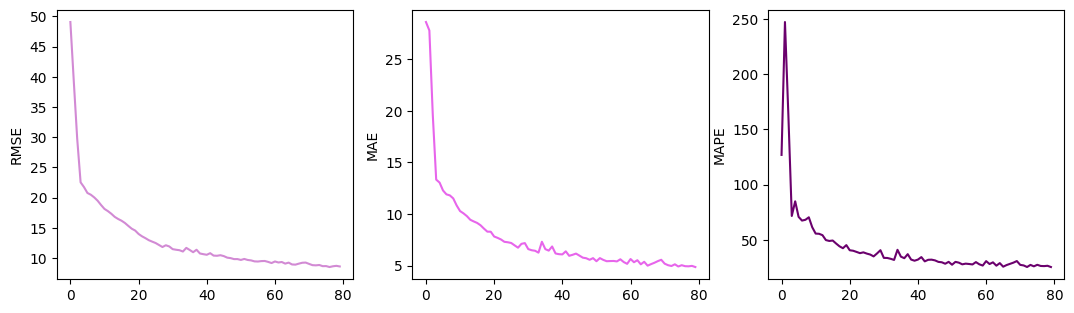

In [5]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, output_size), 
            nn.LeakyReLU()
        )
        
    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :].squeeze(-1)
        x = self.fc(x).squeeze(-1)
        return x


if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size = 256
    learning_rate = 1e-4
    num_epoch = 80
    
    KrakowData = KrakowDataset()
    train_set, val_set, test_set = KrakowData.construct_set(0.6, 0.2)
    train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=14, drop_last=True)
    val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=14, drop_last=True)
    test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=14, drop_last=True)
    input_size = train_set.seqs.shape[-1]
    seq_len = 12
    hidden_size = 512
    output_size = 1

    criterion = nn.MSELoss()
    model = Model(input_size=input_size, hidden_size=hidden_size, output_size=output_size).to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    
    train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, stop_epoch = train(
        net=model, train_iter=train_loader, val_iter=val_loader, test_iter=test_loader, loss_fn=criterion, 
        denormalize_fn=KrakowData.denormalize, optimizer=optimizer, num_epoch=num_epoch, early_stop=20, 
        device=device, num_print_epoch_round=10
    )
    visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
    plot_metric(train_score_lst)

Epoch [10/80], Train Loss: 0.0041, Train RMSE: 73.5435, Val Loss: 0.0041, Val RMSE: 67.405297, Time Use: 0.143s
Epoch [20/80], Train Loss: 0.0033, Train RMSE: 65.6706, Val Loss: 0.0034, Val RMSE: 59.605238, Time Use: 0.142s
Epoch [30/80], Train Loss: 0.0030, Train RMSE: 62.3401, Val Loss: 0.0032, Val RMSE: 56.589227, Time Use: 0.142s
Epoch [40/80], Train Loss: 0.0027, Train RMSE: 59.7001, Val Loss: 0.0030, Val RMSE: 54.232776, Time Use: 0.142s
Epoch [50/80], Train Loss: 0.0025, Train RMSE: 57.2442, Val Loss: 0.0029, Val RMSE: 52.670944, Time Use: 0.142s
Epoch [60/80], Train Loss: 0.0025, Train RMSE: 57.4942, Val Loss: 0.0030, Val RMSE: 55.222252, Time Use: 0.142s
Epoch [70/80], Train Loss: 0.0023, Train RMSE: 55.0742, Val Loss: 0.0029, Val RMSE: 54.733705, Time Use: 0.142s
Epoch [80/80], Train Loss: 0.0023, Train RMSE: 54.8035, Val Loss: 0.0026, Val RMSE: 49.477457, Time Use: 0.144s
Final result: Get best validation rmse 49.4775 at epoch 79, Total time 11.47s
Test result: Test RMSE: 48

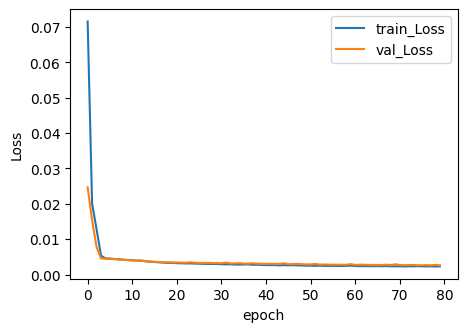

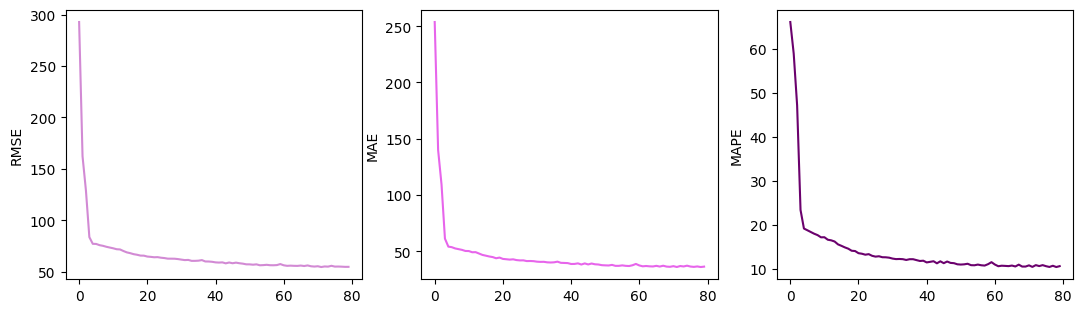

In [6]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size = 256
    learning_rate = 1e-4
    num_epoch = 80
    
    TrafficData = TrafficDataset()
    train_set, val_set, test_set = TrafficData.construct_set(0.6, 0.2)
    train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=14, drop_last=True)
    val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=14, drop_last=True)
    test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=14, drop_last=True)
    input_size = train_set.seqs.shape[-1]
    seq_len = 12
    hidden_size = 512
    output_size = 1

    criterion = nn.MSELoss()
    model = Model(input_size=input_size, hidden_size=hidden_size, output_size=output_size).to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    
    train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, stop_epoch = train(
        net=model, train_iter=train_loader, val_iter=val_loader, test_iter=test_loader, loss_fn=criterion, 
        denormalize_fn=TrafficData.denormalize, optimizer=optimizer, num_epoch=num_epoch, early_stop=20, 
        device=device, num_print_epoch_round=10
    )
    visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
    plot_metric(train_score_lst)